<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [11]:
## install packages
%pip install wrds==3.1.5
# %pip install swig

  Attempting uninstall: wrds
    Found existing installation: wrds 3.1.6
    Uninstalling wrds-3.1.6:
      Successfully uninstalled wrds-3.1.6

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [993 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2139 kB]
Get:6 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [8993 B]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.2 kB]
Get:10 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 Packages [65.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2283 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/mult

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools
import random
import json

/home/ray/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
print(f"DATA_SAVE_DIR: {DATA_SAVE_DIR}")
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



DATA_SAVE_DIR: datasets


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [5]:
# from config.py, TRAIN_START_DATE is a string
print(f"TRAIN_START_DATE: {TRAIN_START_DATE}")
# from config.py, TRAIN_END_DATE is a string
print(f"TRAIN_END_DATE: {TRAIN_END_DATE}")

TRAIN_START_DATE: 2014-01-06
TRAIN_END_DATE: 2020-07-31


In [6]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'

In [7]:
if os.path.exists("extra/yahoo_data.csv"):
    df = pd.read_csv("extra/yahoo_data.csv", index_col=0)
else:
    df = YahooDownloader(
        start_date = TRAIN_START_DATE,
        end_date = TRADE_END_DATE,
        ticker_list = config_tickers.DOW_30_TICKER
    ).fetch_data()
    if not os.path.exists("extra"):
        os.makedirs("extra")
    df.to_csv("extra/yahoo_data.csv")

In [8]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,4.840000,4.940000,4.660000,4.496876,9837300,AAL,0
1,2010-01-04,7.622500,7.660714,7.585000,6.505280,493729600,AAPL,0
2,2010-01-04,36.650002,37.299999,36.650002,37.090000,4710200,ADBE,0
3,2010-01-04,31.790001,32.189999,31.610001,22.960760,2102700,ADI,0
4,2010-01-04,38.226513,38.226513,37.489025,27.336401,3930120,ADP,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [10]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False
)
processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3333, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [12]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAL,4.840000,4.940000,4.660000,4.496876,9837300.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,4.496876,4.496876,20.040001,0.0
1,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.505280,493729600.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,6.505280,6.505280,20.040001,0.0
2,2010-01-04,ADBE,36.650002,37.299999,36.650002,37.090000,4710200.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,37.090000,37.090000,20.040001,0.0
3,2010-01-04,ADI,31.790001,32.189999,31.610001,22.960760,2102700.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,22.960760,22.960760,20.040001,0.0
4,2010-01-04,ADP,38.226513,38.226513,37.489025,27.336401,3930120.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,27.336401,27.336401,20.040001,0.0
5,2010-01-04,ADSK,25.610001,25.830000,25.610001,25.670000,2228600.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,25.670000,25.670000,20.040001,0.0
6,2010-01-04,ALGN,18.049999,18.500000,18.049999,18.500000,374200.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,18.500000,18.500000,20.040001,0.0
7,2010-01-04,AMAT,14.050000,14.570000,14.030000,11.302064,18615100.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,11.302064,11.302064,20.040001,0.0
8,2010-01-04,AMD,9.790000,9.900000,9.680000,9.700000,18748700.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,9.700000,9.700000,20.040001,0.0
9,2010-01-04,AMGN,56.630001,57.869999,56.560001,42.888943,5277400.0,0.0,0.0,5.471367,4.031466,100.0,66.666667,100.0,42.888943,42.888943,20.040001,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [13]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

216562
27634


In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 82, State Space: 821


In [15]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

# e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment Creator for Training in RLLIB

* In RLLIB, an env creator is a function that take as input an EnvContext object (Dict containing the config), and outputs the envirnoment object instanciated with the parameters from the EnvContext.
* We are gonna wrap the envirnoment class in the EnvCompatibility wrapper fro *gymnasium* to account for the changes in the gym API (considered by ray 2.3.0)
* Finally, we are gonna register the environment to ray so that it would be accessible in the DRL trainers.



In [16]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env

# Serve
from ray import serve

from gymnasium.wrappers import EnvCompatibility

In [17]:
def env_creator(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', train)
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling
    ))

<a id='5'></a>
# Part 6: Train RLLIB DRL Agents
* We will initialize a ray instance specifying the resources we put at its disposal
* We will then initialize the config object from the respective default configuration of the algorithm we are going to use. We can then add environment specific parameters, and parallelization specific parameters.
* Finally, we instanciate the trainer and launch the training loop

In [18]:
# %pip install flax==0.5.3
# %pip install jax==0.3.25

In [19]:
from ray.rllib.agents import ppo
# If error here due to Jax, uncomment and run the above cell

* Set this to True if you want to run DDPPO instead of PPO

In [20]:
use_ddppo = True

### Init ray (no need to, ray will automatically restart)

In [21]:
ray.shutdown()
#print(f"ray is being initialized")
#ray.init(_temp_dir="FinRL/RLLIB/results", num_cpus=1, num_gpus=0)
# ray.init()

### Define Config

In [22]:
def make_config():
    if use_ddppo:
        config = ppo.DDPPOConfig()
    else:
        config = ppo.PPOConfig()

    # Here set envirnonment parameters if different from default
    config = config.environment(
        env_config={'hmax':100, 'initial_amount':1000000}
    )

    # Training
    config = config.training()

    # Resources
    config = config.resources(
        num_gpus=0,
        num_cpus_per_worker=1,
        num_gpus_per_worker=0,
        num_trainer_workers=2,
        num_gpus_per_trainer_worker = 0,
        num_cpus_per_trainer_worker = 1,
    )
    # Framework
    config = config.framework(
        framework="torch",
    )
    # Rollouts
    config = config.rollouts(
        num_rollout_workers=2,
        num_envs_per_worker=1,
    )
    
    return config

config = make_config()
    
print(config)
# pretty(config.to_dict())

### Normal Training

In [23]:
from tqdm.notebook import tqdm

In [24]:
register_env("finrl", env_creator)

In [25]:
def train_ppo_model(use_ddppo=use_ddppo, config=config):
    if use_ddppo:
        trainer = ppo.DDPPOTrainer(env='finrl', config=config)
    else:
        trainer = ppo.PPOTrainer(env='finrl', config=config)
    # Train
    # (4) Train away -------------------------------------------------------------
    total_episodes=20
    ep = 0
    results = []
    bar = tqdm(total=total_episodes, desc="Episodes")
    while ep <= total_episodes:
        results.append(trainer.train())
        ep += 1
        bar.update(n=1)
    bar.close()
    # Save state of the trained Algorithm in a checkpoint.
    # save the trained agent
    agent_name = 'ppo'
    if use_ddppo:
        agent_name = 'ddppo'
    cwd_checkpoint = "FinRL/RLLIB/results/checkpoints/" + str(agent_name) + '_' + str(ep)
    checkpoint_dir = trainer.save(cwd_checkpoint)
    return checkpoint_dir

In [26]:
checkpoint_path = train_ppo_model(use_ddppo=use_ddppo, config=config)

2023-04-26 02:04:51,989	WARNING deprecation.py:51 -- DeprecationWarning: `algo = Algorithm(env='finrl', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl').build()` instead. This will raise an error in the future!
2023-04-26 02:04:54,400	WARNING services.py:1791 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67096576 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.94gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-26 02:04:54,461	INFO worker.py:1550 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(RolloutWorker pid=9998) 2023-04-26 02:05:04,180	WARNING env.py:157 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will 

Episodes:   0%|          | 0/20 [00:00<?, ?it/s]

(RolloutWorker pid=9998) 2023-04-26 02:05:17,731	WARNING deprecation.py:51 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=9998) /home/ray/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:1578: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=9998)   "torch.distributed.all_reduce_coalesced will be deprecated. If you must "
(RolloutWorker pid=10011) /home/ray/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:1578: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=10011)   "torch.distributed.all_reduce_coalesced will be 

# Inference using Ray Serve

In [27]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))
register_env("finrl_trading", env_creator_trading)

In [28]:
from starlette.requests import Request

### Deploy Model

In [29]:
@serve.deployment
class ServePPOModel:
    def __init__(self, checkpoint_path) -> None:
        # Re-create the originally used config.
        # Build the Algorithm instance using the config.
        if use_ddppo:
            self.algorithm = ppo.DDPPOTrainer(env='finrl_trading', config=config)
        else:
            self.algorithm = ppo.PPOTrainer(env='finrl_trading', config=config)
        # Restore the algo's state from the checkpoint.
        self.algorithm.restore(checkpoint_path)

    async def __call__(self, request: Request):
        json_input = await request.json()
        obs = json_input["observation"]

        action = self.algorithm.compute_single_action(obs)
        return {"action": action}

### Run server

In [30]:
config = make_config()
ppo_model = ServePPOModel.bind(checkpoint_path)
serve.run(ppo_model)

(ServeController pid=19901) INFO 2023-04-26 02:11:14,629 controller 19901 http_state.py:132 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-c565954c098513bc5bd3917ce7f0ab42d572e242345d55a0e8b435d3' on node 'c565954c098513bc5bd3917ce7f0ab42d572e242345d55a0e8b435d3' listening on '127.0.0.1:8000'
(ServeController pid=19901) INFO 2023-04-26 02:11:16,029 controller 19901 deployment_state.py:1334 - Adding 1 replica to deployment 'ServePPOModel'.
(HTTPProxyActor pid=19988) INFO:     Started server process [19988]
(ServeReplica:ServePPOModel pid=20082) 2023-04-26 02:11:22,062	WARNING deprecation.py:51 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
(ServeReplica:ServePPOModel pid=20082) 2023-04-26 02:11:22,814	INFO algorithm.py:507 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEB

RayServeSyncHandle(deployment='ServePPOModel')

## Testing

In [31]:
import requests

env = env_creator_trading(env_config={})

for _ in range(2):
    obs, _ = env.reset()

    print(f"-> Sending observation (first 10 observations) {obs[:10]}")
    resp = requests.get(
        "http://localhost:8000/", json={"observation": obs}
    )
    print(f"<- Received response (first 10 actions) {resp.json()['action'][:10]}")

-> Sending observation (first 10 observations) [1000000, 12.8100004196167, 89.49456024169922, 439.80999755859375, 114.55582427978516, 141.08291625976562, 241.22000122070312, 273.8399963378906, 58.21044921875, 52.58000183105469]
<- Received response (first 10 actions) [-0.2552473545074463, -1.0, -1.0, -0.7286295890808105, 0.48050224781036377, -1.0, -1.0, 0.8433380126953125, 0.5069377422332764, 0.9469959735870361]
-> Sending observation (first 10 observations) [1000000, 12.8100004196167, 89.49456024169922, 439.80999755859375, 114.55582427978516, 141.08291625976562, 241.22000122070312, 273.8399963378906, 58.21044921875, 52.58000183105469]
<- Received response (first 10 actions) [-0.8856371641159058, -0.3346368670463562, 1.0, -1.0, -0.3922043442726135, 1.0, 0.8363866806030273, 1.0, -0.8109548687934875, -0.22266125679016113]


(HTTPProxyActor pid=19988) INFO 2023-04-26 02:11:38,740 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 19.1ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:11:38,736 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 7.3ms
(HTTPProxyActor pid=19988) INFO 2023-04-26 02:11:38,765 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 10.3ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:11:38,762 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 3.7ms


# Evaluation

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [32]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [33]:
insample_risk_indicator.vix.describe()

count    2641.000000
mean       17.616789
std         7.373543
min         9.140000
25%        13.120000
50%        15.600000
75%        19.370001
max        82.690002
Name: vix, dtype: float64

In [34]:
insample_risk_indicator.vix.quantile(0.996)

59.224801025390796

In [35]:
insample_risk_indicator.turbulence.describe()

count    2641.000000
mean      135.920737
std       147.144369
min         0.000000
25%        67.095410
50%       102.949952
75%       158.653557
max      2429.635717
Name: turbulence, dtype: float64

In [36]:
insample_risk_indicator.turbulence.quantile(0.996)

982.8940728620535

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [37]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

In [74]:
def DRL_prediction(environment):
    """make a prediction"""
    state = environment.reset()
    for i in tqdm(range(len(environment.df.index.unique()))):
        # ############### Ray Serve ###############
        resp = requests.get(
            "http://localhost:8000/", json={"observation": [float(s) for s in state]}
        )
        action = resp.json()['action']
        # print(f"action: {type(np.array(action))}, shape: {np.array(action).shape}")
        # print(f"state type before: {type(state)}, shape: {len(state)}, type elem: {type(state[0])}")
        state, reward, done, _ = environment.step(np.array(action))
        # print(f"state type after: {type(state)}, shape: {len(state)}, type elem: {type(state[0])}")
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            print("hit end!")
            break
    print("Test Finished!")
    return account_memory, actions_memory

In [75]:
df_account_value, df_actions = DRL_prediction(environment = e_trade_gym)

  0%|          | 0/337 [00:00<?, ?it/s]

(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:18,509 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 16.3ms
(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:18,536 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 9.7ms
(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:18,563 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 8.8ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:29:18,505 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 7.6ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:29:18,533 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 3.7ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:29:18,560 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 2.7ms
(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:18,595 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 10.7ms
(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:18,622 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200

hit end!
Test Finished!


(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:26,234 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 11.3ms
(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:26,266 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 14.3ms
(HTTPProxyActor pid=19988) INFO 2023-04-26 02:29:26,306 http_proxy 172.17.0.2 http_proxy.py:378 - GET / 200 7.5ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:29:26,230 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 4.5ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:29:26,262 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 4.7ms
(ServeReplica:ServePPOModel pid=20082) INFO 2023-04-26 02:29:26,304 ServePPOModel ServePPOModel#tYFmRy replica.py:523 - HANDLE __call__ OK 2.7ms


In [76]:
df_account_value.tail()

,date,account_value
332,2021-10-25,1.129706e+06
333,2021-10-26,1.135412e+06
334,2021-10-27,1.117247e+06
335,2021-10-28,1.134019e+06
336,2021-10-29,1.146700e+06


In [77]:
df_actions.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,ALGN,AMAT,AMD,AMGN,...,TXN,UAL,ULTA,VRSK,VRSN,VRTX,WBA,WDC,WYNN,XEL
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,64,74,100,20,100,0,27,0,0,0,...,100,0,0,66,0,0,0,0,0,0
2020-07-02,100,-74,50,-20,-33,0,1,0,0,97,...,-21,9,100,-30,0,95,0,0,9,0
2020-07-06,-23,0,43,100,38,28,-28,7,0,70,...,44,-9,100,-36,0,-27,0,0,100,8
2020-07-07,1,0,0,-31,0,-28,0,-7,0,-100,...,100,0,-33,0,0,0,0,0,0,0
2020-07-08,80,0,8,73,23,37,0,0,100,-46,...,-61,69,-77,23,16,-68,68,0,100,-8


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [78]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.107784
Cumulative returns     0.146700
Annual volatility      0.194853
Sharpe ratio           0.624510
Calmar ratio           0.995663
Stability              0.645457
Max drawdown          -0.108253
Omega ratio            1.108219
Sortino ratio          0.863507
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.983592
Daily value at risk   -0.024066
dtype: float64


In [79]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.279047
Cumulative returns     0.388402
Annual volatility      0.139129
Sharpe ratio           1.844560
Calmar ratio           3.124551
Stability              0.918675
Max drawdown          -0.089308
Omega ratio            1.358960
Sortino ratio          2.734872
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016510
dtype: float64


In [80]:
df_account_value.loc[0,'date']

'2020-07-01'

In [81]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-29'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,10.778%
Cumulative returns,14.67%
Annual volatility,19.485%
Sharpe ratio,0.62
Calmar ratio,1.00
Stability,0.65
Max drawdown,-10.825%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.83,2020-09-02,2020-09-23,2020-10-12,29
1,10.65,2021-02-16,2021-05-12,2021-07-29,118
2,10.20,2021-08-30,2021-10-12,NaT,NaN
3,10.16,2020-10-13,2020-10-30,2020-12-02,37
4,5.77,2021-01-20,2021-01-29,2021-02-08,14


Stress Events,mean,min,max
New Normal,0.05%,-4.75%,3.05%


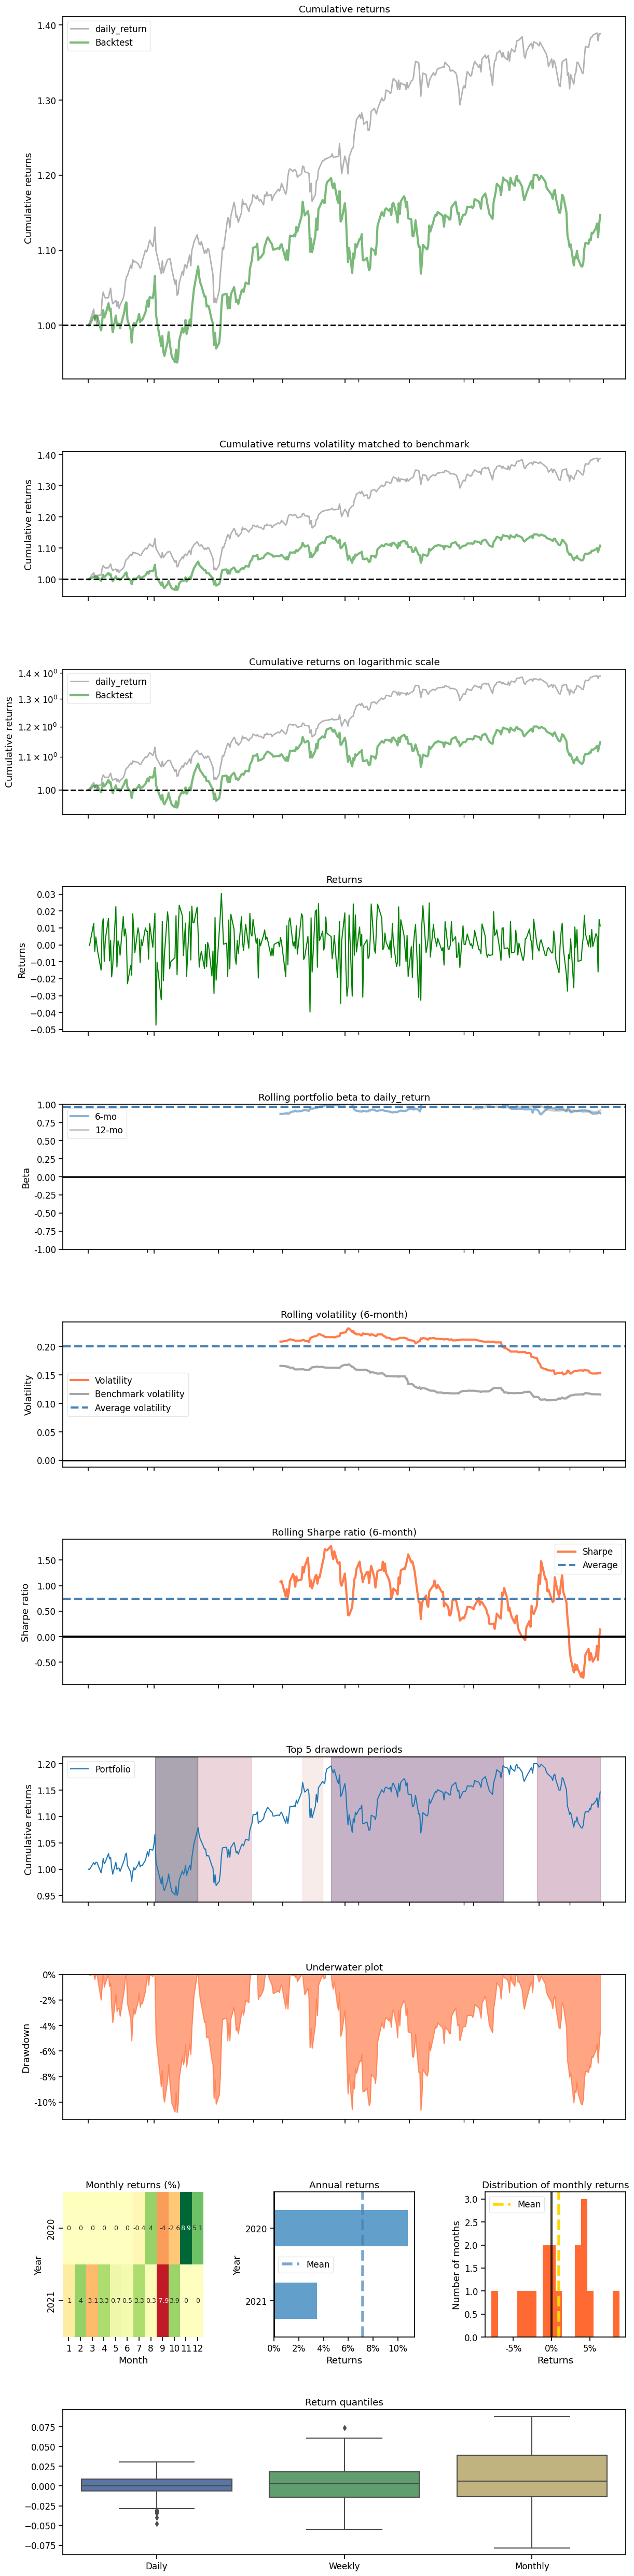

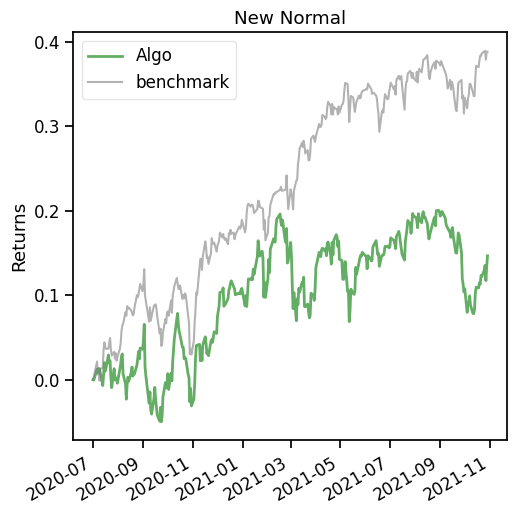

In [82]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])